# Transformer Model for Energy Demand in Spain

## Transformers for Time Series Forecasting

Transformers, originally developed for natural language processing, have become a powerful tool for time series forecasting. Unlike traditional models like ARIMA or gradient-boosted trees, transformers use self-attention mechanisms to capture both short- and long-range dependencies in data.

For energy demand forecasting, transformers can process multiple input features simultaneously, including lagged demand values, weather conditions, calendar effects, and other exogenous variables, without relying on manually defined temporal dependencies.

## Choosing a Transformer Architecture

The model needs to generate 24 hourly predictions for the next day at noon, meaning it must capture sequential dependencies effectively. There are two main transformer architectures to consider:

- **Sequence-to-Sequence (Seq2Seq) Transformer** : This approach uses both an encoder and a decoder. The encoder processes historical data (past demand, weather, etc), extracting meaningful representations. The decoder autoregressively generates each hour’s demand forecast while attending to both the encoder’s outputs and known future data (weather forecasts, calendar effects, etc).
    - Pros : Naturally handles multi-step forecasting by generating predictions one at a time. Can incorporate past predictions dynamically in an autoregressive manner.
    - Cons : Requires masking to ensure predictions don’t leak future information. More computationally expensive due to the decoder’s sequential nature.
- **Encoder-Only Transformer** : This approach uses only an encoder (like BERT-style transformers) to map historical and exogenous features directly to all 24 future hourly predictions in a single forward pass.
    - Pros : Faster and more efficient since it doesn’t require iterative decoding. Avoids error accumulation from autoregressive predictions.
    - Cons : Can struggle with capturing temporal dependencies between consecutive predicted hours. Less flexible in handling exogenous variables that evolve dynamically.

For this task, an encoder-only transformer will be used since it efficiently predicts all 24 future time steps in one forward pass. While Seq2Seq models better capture sequential dependencies, their computational cost and risk of accumulating errors make them less suitable for predicting 36 hours ahead (12 historical + 24 future time steps).

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Feature Engineering

The pre-cleaned dataset from [xgboost_demand.ipynb](xgboost_demand.ipynb) can be reused for the transformer model, but adjustments are needed in the feature engineering step. Unlike XGBoost, which treated each time step as a separate row with extracted lag-based features, the transformer model requires the data to be structured as a sequence. This means that instead of having a single feature vector per prediction (num_features), the input to the transformer will be a (24, num_features) matrix, preserving the temporal relationships within each 24-hour window.

In [2]:
df = pd.read_csv('data/demand_df.csv')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

cities = ['madrid', 'barcelona', 'valencia', 'sevilla', 'bilbao']
# City population density weights
city_weights = {'madrid' : 0.269779,
                'barcelona' : 0.202184,
                'valencia' : 0.200026,
                'sevilla' : 0.186186,
                'bilbao' : 0.141825}

# Create difference between temperature and feelslike feature
for city in cities:
    df[f'feelslike_diff_{city}'] = df[f'temp_{city}'] - df[f'feelslike_{city}']

columns = ['temp', 'feelslike_diff', 'dew', 'humidity', 'precip', 'precipprob', 'snow', 'snowdepth', 'windgust', 'windspeed',
                'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation']

df_final = df[['datetime', 'Actual Total Load (MW)']].copy()

for column in columns:
    df_final[f'weighted_{column}'] = sum(df[f'{column}_{city}'] * weight for city, weight in city_weights.items())
df_final = df_final.round(2)

df_final = df_final.set_index('datetime')

df_final['date'] = df_final.index.date
df_final['hour'] = df_final.index.hour
df_final['day_of_week'] = df_final.index.dayofweek
df_final['month'] = df_final.index.month - 1  # Minus 1 to fit to range 0-11 instead of 1-12
df_final['year'] = df_final.index.year - 2018

# Cyclical encoding of features for hour, day_of_week and month
df_final['hour_sin'] = np.sin(2 * np.pi * df_final['hour'] / 24)
df_final['hour_cos'] = np.cos(2 * np.pi * df_final['hour'] / 24)
df_final['day_of_week_sin'] = np.sin(2 * np.pi * df_final['day_of_week'] / 7)
df_final['day_of_week_cos'] = np.cos(2 * np.pi * df_final['day_of_week'] / 7)
df_final['month_sin'] = np.sin(2 * np.pi * df_final['month'] / 12)
df_final['month_cos'] = np.cos(2 * np.pi * df_final['month'] / 12)

# National Holiday Data
dates_df = pd.read_csv('data/national_holidays.csv', parse_dates=['date'])
dates_list = dates_df['date'].dt.date
df_final['holiday_bool'] = df_final.date.isin(dates_list).astype(int)


df_final['day_shifted_demand'] = np.where(
    df_final['hour'] < 12,
    df_final['Actual Total Load (MW)'].shift(24),  # Use 24-hour shift if hour < 12
    df_final['Actual Total Load (MW)'].shift(48)   # Use 48-hour shift if hour >= 12
)

df_final['week_shifted_demand'] = df_final['Actual Total Load (MW)'].shift(168)

df_final.drop(['date', 'hour', 'day_of_week', 'month'], axis=1, inplace=True)
df_final = df_final[168:-1]

print(df_final.columns)


Index(['Actual Total Load (MW)', 'weighted_temp', 'weighted_feelslike_diff',
       'weighted_dew', 'weighted_humidity', 'weighted_precip',
       'weighted_precipprob', 'weighted_snow', 'weighted_snowdepth',
       'weighted_windgust', 'weighted_windspeed', 'weighted_winddir',
       'weighted_sealevelpressure', 'weighted_cloudcover',
       'weighted_visibility', 'weighted_solarradiation', 'year', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'holiday_bool', 'day_shifted_demand',
       'week_shifted_demand'],
      dtype='object')


The transformer model requires more training data than XGBoost, so using one data point per day is insufficient. To address this, we will create one data point for each hour of the day, increasing the amount of training data and allowing the model to learn richer temporal patterns. While the transformer will still only make predictions for each hour (0-23) of the following day at noon, using data for other hours can still provide valuable context. This extra data can help the model capture long-term trends, making it more generalised and improving its overall forecasting accuracy.

In [3]:
num_days = len(df_final) // 24
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_numerical = df_final.drop(columns=['Actual Total Load (MW)'])
X_numerical_normal = scaler_X.fit_transform(X_numerical)
X_numerical_norm = np.lib.stride_tricks.sliding_window_view(X_numerical_normal, window_shape=(24, X_numerical.shape[1])).squeeze(axis=1)
print(X_numerical_norm.shape)

y = df_final['Actual Total Load (MW)'].values.reshape(-1, 1)
y_normal = scaler_y.fit_transform(y)
y_norm = np.lib.stride_tricks.sliding_window_view(y_normal, window_shape=(24, 1)).squeeze(axis=1).squeeze(axis=2)
print(y_norm.shape)

indices_to_remove = np.arange(0, X_numerical_norm.shape[0], 24)
X_numerical_norm_no_12 = np.delete(X_numerical_norm, indices_to_remove, axis=0)
y_norm_no_12 = np.delete(y_norm, indices_to_remove, axis=0)
print(y_norm_no_12.shape)

X_numerical_norm_12 = X_numerical_normal.reshape(num_days, 24, -1)
y_norm_12 = y_normal.reshape(num_days, 24)
print(y_norm_12.shape)

(43657, 24, 25)
(43657, 24)
(41837, 24)
(1820, 24)


In [4]:
# Take the last 20% of samples as the test set
X_num_test_12 = X_numerical_norm_12[1456:]
y_test_12 = y_norm_12[1456:]

# Use the rest as the training set
X_num_train_12 = X_numerical_norm_12[:1456]
y_train_12 = y_norm_12[:1456]

X_num_test = X_numerical_norm_no_12[33468:]
y_test = y_norm_no_12[33468:]

X_num_train_temp = X_numerical_norm_no_12[:33468]
y_train_temp = y_norm_no_12[:33468]

X_num_train = np.append(X_num_train_temp, X_num_train_12, axis=0)
y_train = np.append(y_train_temp, y_train_12, axis=0)

# Convert to PyTorch tensors
X_num_train = torch.tensor(X_num_train, dtype=torch.float32)
X_num_train_12 = torch.tensor(X_num_train_12, dtype=torch.float32)
X_num_test = torch.tensor(X_num_test, dtype=torch.float32)
X_num_test_12 = torch.tensor(X_num_test_12, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train_12 = torch.tensor(y_train_12, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_test_12 = torch.tensor(y_test_12, dtype=torch.float32)

## Model Architecture

- **Learnable Positional Encoding**: Adds positional information to the input sequence to help the model capture the order of time steps
    
- **Linear Layer** : Projects the input features to a higher-dimensional space (d_model) for better representation and compatibility with the transformer
    - Learnable input features like day_of_week and month were considered, but failed to work effectively due to the limited training data. With insufficient data, the model struggled to capture meaningful patterns in these cyclical features, leading to poor generalization.

- **Transformer Encoder** : Learns complex dependencies in the input sequence through multi-head self-attention and feedforward networks

- **Output Layer** : Converts the encoder's final output into predictions for each time step (energy demand)

### Hyperparameters
- `d_model = 64` - dimensionality of the model's hidden states
- `dim_feedforward = 256` - size of the feedforward network inside each transformer layer
- `num_layers = 4` - number of transformer layers stacked in the encoder
- `dropout = 0.4` - dropout rate used for regularization to prevent overfitting
- `learning_rate = 0.0005` - step size used in optimization
- `betas = (0.9, 0.98)` - beta parameters for the Adam optimizer. Balance momentum (β1 = 0.9) and the adaptive learning rate (β2 = 0.98)

The chosen hyperparameters strike a balance between model capacity and regularisation, with a smaller d_model and dim_feedforward to prevent overfitting on the limited dataset. The high dropout rate and low learning_rate ensure stable training, while the selected betas help the optimizer adapt effectively, promoting generalisation despite the small data size.

In [5]:
class EnergyDemandForecast(nn.Module):
    def __init__(self, num_features, d_model=64, dim_feedforward=256, nhead=4, num_layers=4, target_length=24, dropout=0.4):
        super(EnergyDemandForecast, self).__init__()

        # --- Learnable Positional Encoding ---
        self.pos_embedding = nn.Parameter(torch.randn(1, target_length, d_model))

        self.feature_projection = nn.Linear(num_features, d_model)

        # --- Transformer Encoder ---
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # --- Final Output Layer ---
        self.fc = nn.Linear(d_model, 1)

    def forward(self, numerical_features):
        """
        Inputs:
        - numerical_features: (batch_size, 24, num_features) -> Past and future features for each timestep
        """

        features = self.feature_projection(numerical_features)  # (batch_size, 24, d_model)

        # --- Add Positional Encoding ---
        features += self.pos_embedding  # (batch_size, 24, d_model)

        # --- Transformer Encoder ---
        encoded_features = self.encoder(features)  # (batch_size, 24, d_model)

        # --- Predict Energy Demand ---
        output = self.fc(encoded_features).squeeze(-1)  # (batch_size, 24)

        return output

In [6]:
# Create TensorDatasets
train_dataset = TensorDataset(X_num_train, y_train)
test_dataset = TensorDataset(X_num_test, y_test)
train_12_dataset = TensorDataset(X_num_train_12, y_train_12)
test_12_dataset = TensorDataset(X_num_test_12, y_test_12)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_12_loader = DataLoader(train_12_dataset, batch_size=32, shuffle=True)
test_12_loader = DataLoader(test_12_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnergyDemandForecast(num_features=25).to(device)
loss_function = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98))


In [7]:
# Training loop
num_epochs = 20
patience = 7  # Number of epochs with no improvement to wait before stopping
best_val_loss = np.inf
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    total_loss = 0

    # Training phase
    for batch in train_loader:
        num_feat, y = [b.to(device) for b in batch]  # Move batch to device

        optimizer.zero_grad()  # Reset gradients
        predictions = model(num_feat)  # Forward pass
        loss = loss_function(predictions, y)  # Compute loss
        loss.backward()
        optimizer.step()  # Update weights
        total_loss += loss.mean().item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():  # No gradient tracking during validation
        for batch in test_loader:
            num_feat, y = [b.to(device) for b in batch]  # Move batch to device

            predictions = model(num_feat)  # Forward pass
            loss = loss_function(predictions, y)  # Compute loss
            loss_mean = loss.mean()
            val_loss += loss_mean.item()

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, "
        f"Training Loss: {total_loss / len(train_loader):.4f}, "
        f"Validation Loss: {val_loss / len(test_loader):.4f}")

    # Early stopping: Check if the validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Stop training if validation loss hasn't improved for 'patience' epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
        break

print("Training complete!")

Epoch 1/20, Training Loss: 0.1277, Validation Loss: 0.0832
Epoch 2/20, Training Loss: 0.0514, Validation Loss: 0.0561
Epoch 3/20, Training Loss: 0.0372, Validation Loss: 0.0487
Epoch 4/20, Training Loss: 0.0300, Validation Loss: 0.0513
Epoch 5/20, Training Loss: 0.0250, Validation Loss: 0.0575
Epoch 6/20, Training Loss: 0.0219, Validation Loss: 0.0408
Epoch 7/20, Training Loss: 0.0195, Validation Loss: 0.0518
Epoch 8/20, Training Loss: 0.0177, Validation Loss: 0.0383
Epoch 9/20, Training Loss: 0.0163, Validation Loss: 0.0395
Epoch 10/20, Training Loss: 0.0150, Validation Loss: 0.0525
Epoch 11/20, Training Loss: 0.0139, Validation Loss: 0.0487
Epoch 12/20, Training Loss: 0.0131, Validation Loss: 0.0405
Epoch 13/20, Training Loss: 0.0123, Validation Loss: 0.0545
Epoch 14/20, Training Loss: 0.0118, Validation Loss: 0.0370
Epoch 15/20, Training Loss: 0.0112, Validation Loss: 0.0553
Epoch 16/20, Training Loss: 0.0107, Validation Loss: 0.0558
Epoch 17/20, Training Loss: 0.0104, Validation Lo

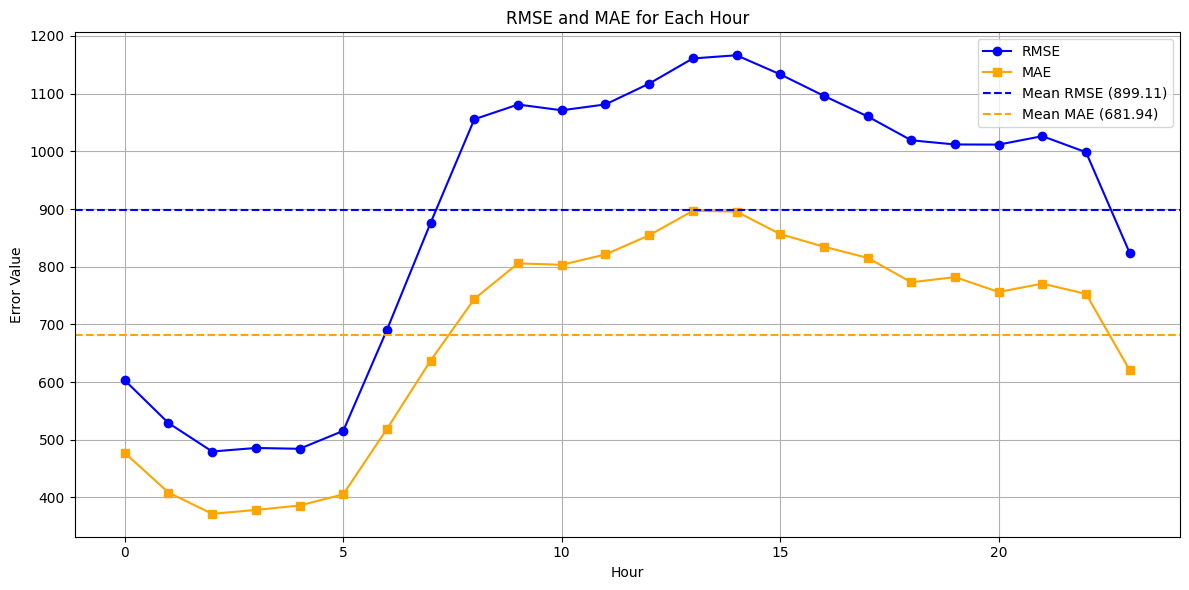

MAPE: 2.57%


In [8]:
# Initialize lists for storing actual and predicted values
all_predictions = []
all_actuals = []

# Iterate over test DataLoader (if using DataLoader, otherwise use test tensors directly)
model.eval()
for batch in test_12_loader:
    num_feat, y_actual = [b.to(device) for b in batch]  # Move to device (CPU/GPU)

    with torch.no_grad():  # No gradient tracking
        y_pred = model(num_feat)  # Get predictions

    all_predictions.append(y_pred.cpu().numpy())  # Store predictions
    all_actuals.append(y_actual.cpu().numpy())  # Store actual values

# Convert lists to numpy arrays
all_predictions = np.concatenate(all_predictions, axis=0)  # Shape: (num_test_samples, 24)
all_actuals = np.concatenate(all_actuals, axis=0)  # Shape: (num_test_samples, 24)

all_predictions_original = scaler_y.inverse_transform(all_predictions)  # Convert back to real MW values
all_actuals_original = scaler_y.inverse_transform(all_actuals)

mae = mean_absolute_error(all_actuals_original, all_predictions_original, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(all_actuals_original, all_predictions_original, multioutput='raw_values'))
mean_rmse = np.mean(rmse)
mean_mae = np.mean(mae)
mape = np.mean(np.abs((all_actuals_original - all_predictions_original) / all_actuals_original)) * 100

plt.figure(figsize=(12, 6))
plt.plot(rmse, label='RMSE', marker='o', linestyle='-', color='blue')
plt.plot(mae, label='MAE', marker='s', linestyle='-', color='orange')
plt.axhline(mean_rmse, color='blue', linestyle='--', label=f'Mean RMSE ({mean_rmse:.2f})')
plt.axhline(mean_mae, color='orange', linestyle='--', label=f'Mean MAE ({mean_mae:.2f})')

plt.title('RMSE and MAE for Each Hour')
plt.xlabel('Hour')
plt.ylabel('Error Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"MAPE: {mape:.2f}%")

In [9]:
# Save the trained model
torch.save(model.state_dict(), "models/transformer_model_state.pth")

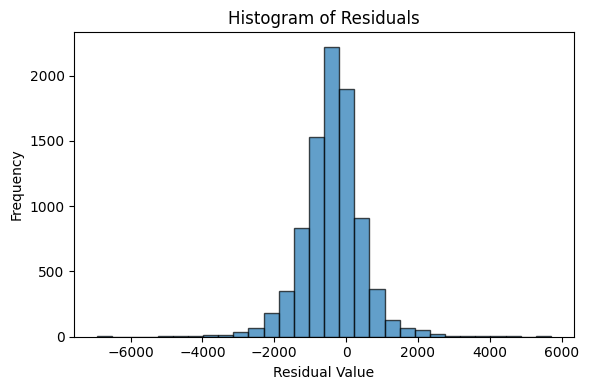

In [10]:
y_errors = all_predictions_original-all_actuals_original
y_errors_flattened = y_errors.flatten()

plt.figure(figsize=(6, 4))
plt.hist(y_errors_flattened, bins=30, edgecolor="k", alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Summary

The Transformer model achieved a Root Mean Squared Error (RMSE) of 899.11 MW, a Mean Absolute Error (MAE) of 681.94 MW, and a Mean Absolute Percentage Error (MAPE) of 2.57%. Therefore, the model is 97.43% accurate. This is significantly better that the benchmark model, however it was still outperformed by the XGBoost model with RMSE of 851.66 MW, MAE of 632.62 MW, and MAPE of 2.39%.

The XGBoost model outperformed the Transformer model primarily due to the limited dataset size. The XGBoost model benefits from handcrafted lag-based features, which explicitly encode temporal dependencies. In contrast, the transformer model relies on self-attention to learn these relationships, which requires significantly more data to generalise effectively. Additionally, Transformers have higher model complexity, making them more prone to overfitting on small datasets, whereas XGBoost’s built-in regularisation techniques help maintain robust performance.

The histogram of residuals indicates that the Transformer model systematically overpredicts energy demand more often than it underpredicts. Since this effect was not observed in the XGBoost model, it is unlikely to be caused by bias in the training data. Instead, it may be a consequence of the Transformer being trained on a more generalised dataset, where predictions were made at every hour rather than specifically at noon each day, potentially reducing its ability to capture noon-specific demand patterns accurately.